# Dataset Analysis for AKKODIS

## Overview

The Akkodis Dataset consists of 40 columns and 21,277 entries. Each candidate is identified by its `ID` and can appear in more than one row, each one specific for an `Event_type__val`.

## Dataset Description

### Features
* **ID**: unique identifier for the candidate
* **Candidate State**: status of the candidate's application
  * `Hired`: the candidate has been selected
  * `Vivier`: the candidate will be taken in consideration for future opportunities
  * `QM`: *Qualification Meeting* ??
  * `In selection`: selection phase
  * `First contact`: the candidate has been contacted from the company for the first time
  * `Economic proposal`: the company has made a proposal to the candidate
  * `Imported`: the candidate has been transfered from another DB ??
* **Age Range**: range of age for the candidate
  * `< 20` years
  * `20 - 25` years
  * `26 - 30` years
  * `31 - 35` years
  * `36 - 40` years
  * `40 - 45` years
  * `> 45` years
* **Residence**: current place of residence for the candidate
* **Sex**: gender identification (`Male|Female`)
* **Protected Category**: indicates if the candidate falls into a protected category
  * `Article 1`
  * `Article 18`
  * Not Specified
* **TAG**: keywords used by recruiter
* **Study Area**: Field of study or academic discipline
* **Study Title**: Academic degree or title obtained
  * `Five-year degree`
  * `Doctorate`
  * `High school graduation`
  * `Three-year degree`
  * `master's degree`
  * `Professional qualification`
  * `Middle school diploma`
* **Years Experience**: number of years of professional experience
  * `0`
  * `0-1`
  * `1-3`
  * `3-5`
  * `5-7`
  * `7-10`
  * `+10`
* **Sector**: industry or sector in which the candidate has experience
* **Last Role**: candidate's most recent job role
* **Year of Insertion**: year when the candidate's information was entered into the portal
* **Year of Recruitment**: year in which the candidate was hired
* **Recruitment Request**: represents the application request for a candidacy
* **Assumption Headquarters**: headquarters location associated with the hiring assumption
* **Job Family Hiring**: Job family or category for the hiring position
* **Job Title Hiring**: specific job title for the hiring position
* **Event_type__val**: It specifies the stage of the recruitment process for the candidate
* **Event_feedback**: feedback received from an event (`OK|KO`)
* **Linked_search_key**: keys indicate the number of searches conducted for a job position
* **Overall**: overall assessment, interview score
  * `1 - Low` or `~ 1 - Low`
  * `2 - Medium` or `~ 2 - Medium`
  * `3 - High` or `~ 3 - High`
  * `4 - Top` or `~ 4 - Top`
* **Job Description**: description of the job role
* **Candidate Profile**: ideal profile information for the candidate, requested by the company
* **Years Experience.1**: additional field for specifying years of experience requested
* **Minimum Ral** (Gross Annual Salary): minimum expected gross annual salary
* **Ral Maximum**: maximum expected gross annual salary
* **Study Level**: level of study requested for the job position, the values are equivalent to `Study Title`
* **Study Area.1**: additional field for specifying the academic field of study requested
* **Akkodis headquarters**: headquarters location for Akkodis
* **Current Ral**: current or existing salary
* **Expected Ral**: expected salary
* **Technical Skills**: skills related to technical or specialized expertise from 1 to 4
* **Standing/Position**: standing or position within the organization from 1 to 4
* **Comunication**: communication skills from 1 to 4
* **Maturity**: level of maturity from 1 to 4
* **Dynamism**: level of Dynamism from 1 to 4
* **Mobility**: mobility from 1 to 4
* **English**: proficiency in the English language from 1 to 4



### Possible Target Variables
Some possible target variables in this dataset could be:
* **Suitability**: a new column that defines if a candidate is suitable for the position, based on the information provided.
* **Possible RAL**: a new column that predicts the adequate RAL for the candidate profile.

In [80]:
#imports
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset_path = 'Dataset_2.0_Akkodis.xlsx'

df = pd.read_excel(dataset_path)

In [3]:
df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.title()

However the dataset contains very few samples with RAL values specified:

In [4]:
for col in df.columns:
  if 'Ral' in col:
    ral_null = df[col].isna().sum() / df.shape[0] * 100
    print(f'{ral_null:.2f}% of samples have no {col} specified')

94.53% of samples have no Minimum Ral specified
92.85% of samples have no Ral Maximum specified
80.56% of samples have no Current Ral specified
80.73% of samples have no Expected Ral specified


The **suitability** of a candidate could be obtained through `Candidate State` and `Event_Feedback`. However the 2 columns don't seem to be always consistent as we can find samples with both `Hired` as *Candidate State* and `KO` as *Event_feedback*:

In [5]:
filtered_df = df[df['Event_Feedback'].str.contains('KO', na=False)]
unique_values = filtered_df['Candidate State'].unique()

print(df[df['Event_Feedback'].str.contains('KO', na=False)][['Candidate State', 'Event_Type__Val', 'Event_Feedback']])

         Candidate State        Event_Type__Val              Event_Feedback
13                    QM  Qualification Meeting       KO (technical skills)
87                 Hired    Technical interview     KO (opportunity closed)
112                Hired    Technical interview  KO (proposed renunciation)
122    Economic proposal      Economic proposal  KO (proposed renunciation)
141         In selection           BM interview                KO (manager)
...                  ...                    ...                         ...
21281       In selection           HR interview       KO (technical skills)
21300  Economic proposal      Economic proposal  KO (proposed renunciation)
21315       In selection           HR interview                KO (manager)
21316       In selection           BM interview                KO (manager)
21336       In selection           HR interview                KO (retired)

[854 rows x 3 columns]


##Data Cleaning
###Duplicates

Each candidate has more than one row in the dataset, one for each `Event_type__val`. We need to select the most recent one and remove the other ones to guarantee consistency. We could assume the last row for each `ID` to be the most recent one.

In [6]:
df_nodup = df.drop_duplicates(subset='Id', keep='last')

This however reduces drastically the number of samples in the dataset, from 21 377 to 12 263 rows, removing the 43% of the whole dataset.

In [7]:
print(f"{100 - df_nodup.shape[0]/df.shape[0]*100:.2f}% of the dataset were duplicates")

42.63% of the dataset were duplicates


### Unuseful Columns

Some columns might be unuseful such as `ID`, `Year Of Insertion`, `Linked_Search__Key` ...

In [11]:
columns_to_drop = ['Id', 'Last Role', 'Year Of Insertion',
                   'Assumption Headquarters', 'Linked_Search__Key',
                   'Akkodis Headquarters']

Some features are often not specified so filling with *default values* might not be the right choice. A **threshold** could be set to select the columns to drop. For example features specified in less than 40% of the samples could be considered unuseful.

In [12]:
for col in df.columns:
  null_count = df[col].isna().sum() / df.shape[0]
  print(f'<{col}> null count: {null_count*100:.2f}%')
  if null_count > 0.6 and col != 'Event_Feedback' and col != 'Protected Category':
    columns_to_drop.append(col)

<Id> null count: 0.00%
<Candidate State> null count: 0.00%
<Age Range> null count: 0.00%
<Residence> null count: 0.01%
<Sex> null count: 0.00%
<Protected Category> null count: 99.60%
<Tag> null count: 50.19%
<Study Area> null count: 0.21%
<Study Title> null count: 0.00%
<Years Experience> null count: 0.00%
<Sector> null count: 42.86%
<Last Role> null count: 42.86%
<Year Of Insertion> null count: 0.00%
<Year Of Recruitment> null count: 88.82%
<Recruitment Request> null count: 90.20%
<Assumption Headquarters> null count: 88.86%
<Job Family Hiring> null count: 88.86%
<Job Title Hiring> null count: 88.86%
<Event_Type__Val> null count: 7.44%
<Event_Feedback> null count: 72.65%
<Linked_Search__Key> null count: 70.41%
<Overall> null count: 72.01%
<Job Description> null count: 90.09%
<Candidate Profile> null count: 90.22%
<Years Experience.1> null count: 90.08%
<Minimum Ral> null count: 94.53%
<Ral Maximum> null count: 92.85%
<Study Level> null count: 90.08%
<Study Area.1> null count: 90.08%
<

In [13]:
df = df_nodup.drop(columns=columns_to_drop)

In [14]:
print(f'The remaining columns are:\n')
print(df.columns)

The remaining columns are:

Index(['Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected Category', 'Tag', 'Study Area', 'Study Title',
       'Years Experience', 'Sector', 'Event_Type__Val', 'Event_Feedback'],
      dtype='object')


### NaNs Handling
There are still many columns left with no values specified.

In [15]:
print(f'Columns that contain NaN values:\n {df.columns[df.isnull().any()].tolist()}')

Columns that contain NaN values:
 ['Residence', 'Protected Category', 'Tag', 'Study Area', 'Sector', 'Event_Type__Val', 'Event_Feedback']


In order to define *default values* we need to analyze each feature:

In [16]:
for col in df.columns[df.isnull().any()].tolist():
  print(f'{col} values: {df[col].unique()} \n')

Residence values: ['TURIN » Turin ~ Piedmont' 'CONVERSANO » Bari ~ Puglia'
 'CASERTA » Caserta ~ Campania' ...
 'SAN FELICE A CANCELLO » Caserta ~ Campania'
 'PERDIFUMO » Salerno ~ Campania'
 'PALMANOVA » Udine ~ Friuli Venezia Giulia'] 

Protected Category values: [nan 'Article 1' 'Article 18'] 

Tag values: ['AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/VENUS, VHDL, FPGA'
 '-, C, C++, DO178, LABVIEW, SOFTWARE DEVELOPMENT' 'PROCESS ENG.' ...
 '-, SOLIDWORKS, NX, CREO, INENTOR, GT POWER, AMESIM' 'SQL, UNIX'
 '-, ENVIRONMENTAL QUALITY, ENVIRONMENTAL MANAGER, ENVIRONMENTAL PROJECT ENGINEER, ISO 14001, ENVIRONMENTAL MANAGEMENT , ISO 14001, ENVIRONMENTAL MANAGEMENT, OFFSHORE'] 

Study Area values: ['Automation/Mechatronics Engineering' 'computer engineering'
 'chemical engineering' 'Legal' 'Mechanical engineering'
 'Telecommunications Engineering' 'Economic - Statistics'
 'Materials Science and Engineering' 'Other scientific subjects'
 'Biomedical Engineering' 'electronic Engineering'
 'I

Some default values could be:

In [17]:
df['Residence'] = df['Residence'].fillna('Not Specified')

df['Protected Category'] = df['Protected Category'].fillna('No')

df['Tag'] = df['Tag'].fillna('Not Specified')

df['Study Area'] = df['Study Area'].fillna('Not Specified')

df['Sector'] = df['Sector'].fillna('Not Specified')

df['Event_Type__Val'] = df['Event_Type__Val'].fillna('Not Specified')

df['Event_Feedback'] = df['Event_Feedback'].fillna('Not Specified')

### Feature Mapping
Feature mapping can be used to simplify the values in the dataset.

Let's analyze each feature:
  

####  **Candidate State**

Text(0, 0.5, 'Frequency')

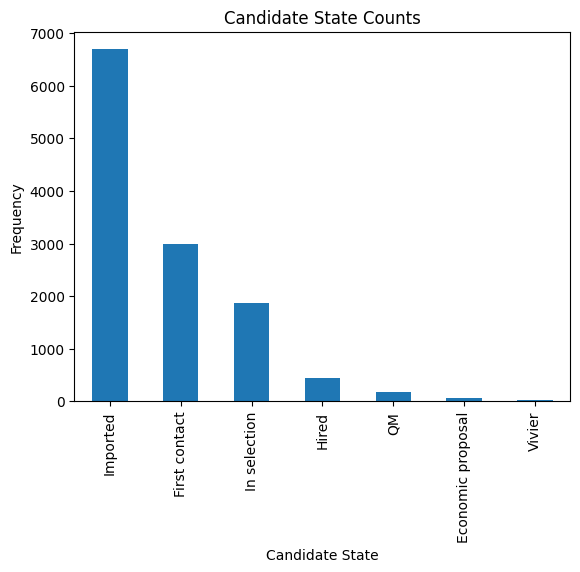

In [18]:
candidate_state_counts = df['Candidate State'].value_counts()
candidate_state_df = pd.DataFrame(candidate_state_counts.items(), columns=['Candidate State', 'Count'])
candidate_state_df.plot(x='Candidate State', y='Count', kind='bar', legend=False)
plt.title('Candidate State Counts')
plt.ylabel('Frequency')

#### **Age Range**

In [19]:
custom_order = ['< 20 years', '20 - 25 years', '26 - 30 years',
                '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years']
df['Age Range'] = pd.Categorical(df['Age Range'], categories=custom_order, ordered=True)

Text(0, 0.5, 'Frequency')

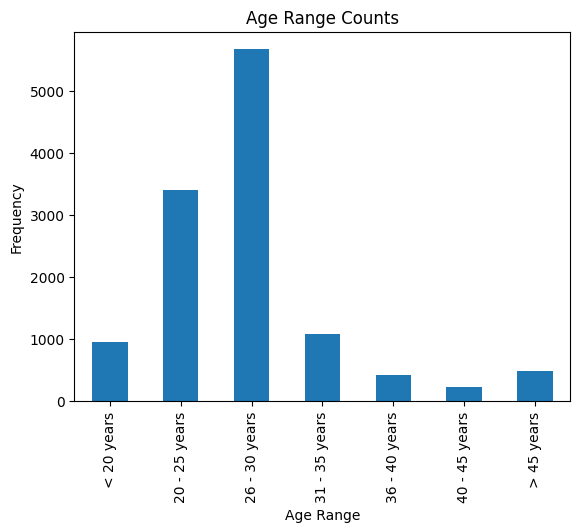

In [20]:
age_range_counts = Counter(df['Age Range'].sort_values())
age_range_df = pd.DataFrame(age_range_counts.items(), columns=['Age Range', 'Count'])
age_range_df.plot(x='Age Range', y='Count', kind='bar', legend=False)
plt.title('Age Range Counts')
plt.ylabel('Frequency')

#### **Residence**
Mapping can be used to simplify this feature.

In [21]:
print(df['Residence'].unique())

['TURIN » Turin ~ Piedmont' 'CONVERSANO » Bari ~ Puglia'
 'CASERTA » Caserta ~ Campania' ...
 'SAN FELICE A CANCELLO » Caserta ~ Campania'
 'PERDIFUMO » Salerno ~ Campania'
 'PALMANOVA » Udine ~ Friuli Venezia Giulia']


In [22]:
residence_list = df['Residence'].unique()
state_list = [s for s in residence_list if ('(STATE)' in s) or ('(OVERSEAS)' in s) or ('ETHIOPIA' in s) or ('SOUTH AFRICAN REPUBLIC' in s) or ('USSR' in s) or ('YUGOSLAVIA' in s)]
state_list = [s.split(' » ')[0] for s in [s.split(' ~ ')[0] for s in state_list]]
state_list = sorted(set(state_list))
print(f"List of residence states of the candidates in the dataset:\n {state_list}")


List of residence states of the candidates in the dataset:
 ['ALBANIA', 'ALGERIA', 'AUSTRIA', 'BELARUS', 'BELGIUM', 'BRAZIL', 'BULGARIA', 'CHILE', "CHINA PEOPLE'S REPUBLIC", 'COLOMBIA', 'CROATIA', 'CZECH REPUBLIC', 'EGYPT', 'ERITREA', 'FRANCE', 'GERMANY', 'GREAT BRITAIN-NORTHERN IRELAND', 'GREECE', 'GRENADA', 'HAITI', 'INDIA', 'INDONESIA', 'IRAN', 'ITALY', 'KUWAIT', 'LEBANON', 'LIBYA', 'LITHUANIA', 'MALAYSIA', 'MALTA', 'MEXICO', 'MONACO', 'MOROCCO', 'NETHERLANDS', 'NIGERIA', 'OMAN', 'PAKISTAN', 'PHILIPPINES', 'PORTUGAL', 'QATAR', 'REPUBLIC OF POLAND', 'ROMANIA', 'RUSSIAN FEDERATION', 'SAINT LUCIA', 'SAINT PIERRE ET MIQUELON (ISLANDS)', 'SAN MARINO', 'SERBIA AND MONTENEGRO', 'SINGAPORE', 'SLOVAKIA', 'SOUTH AFRICAN REPUBLIC', 'SPAIN', 'SRI LANKA', 'SWEDEN', 'SWITZERLAND', 'SYRIA', 'TONGA', 'TUNISIA', 'Türkiye', 'UKRAINE', 'UNITED ARAB EMIRATES', 'UNITED STATES OF AMERICA', 'USSR', 'UZBEKISTAN', 'VENEZUELA', 'YUGOSLAVIA']


In [23]:
italy_list = [s for s in residence_list if ('(STATE)' not in s) and ('(OVERSEAS)' not in s) and ('ETHIOPIA' not in s) and ('SOUTH AFRICAN REPUBLIC' not in s) and ('USSR' not in s) and ('YUGOSLAVIA' not in s)]
italy_list = [s.split(' ~ ')[-1] for s in italy_list]
italy_list = sorted(set(italy_list))
print(f"List of residence italian regions of the candidates in the dataset:\n {italy_list}")

List of residence italian regions of the candidates in the dataset:
 ['Abruzzo', 'Aosta Valley', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardy', 'Marche', 'Molise', 'Not Specified', 'Piedmont', 'Puglia', 'Sardinia', 'Sicily', 'Trentino Alto Adige', 'Tuscany', 'Umbria', 'Veneto']


In [24]:
def map_residence(value):
    for region in italy_list:
        if region in value:
          return region
    for state in state_list:
        if state in value:
          return state
    return 'Not Specified'


The values in the `Residence` column could be replaced with either the *italian region* or the *state*.

In [25]:
df['Residence'] = df['Residence'].apply(map_residence)
df['Residence'] = df['Residence'].replace('Türkiye', 'TURKEY')
df['Residence'] = df['Residence'].replace('USSR', 'RUSSIAN FEDERATION')

To better define *residence* 3 new columns could be added:
`Residence State`, `Residence Italian Region`, `European Residence`. This kind of information needs to be protected but should also be taken in consideration in order to ensure *Fairness*.

In [26]:
df['Residence State'] = df['Residence'].apply(lambda x: x if x in state_list else 'ITALY')

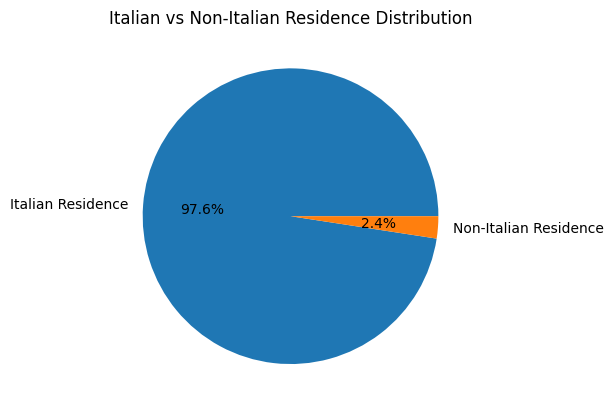

In [27]:
distrib_it = [len(df[df['Residence State'] == 'ITALY']),
                df.shape[0]-len(df[df['Residence State'] == 'ITALY'])]
labels = ['Italian Residence', 'Non-Italian Residence']
plt.pie(distrib_it, labels=labels, autopct='%1.1f%%')
plt.title('Italian vs Non-Italian Residence Distribution')
plt.show()

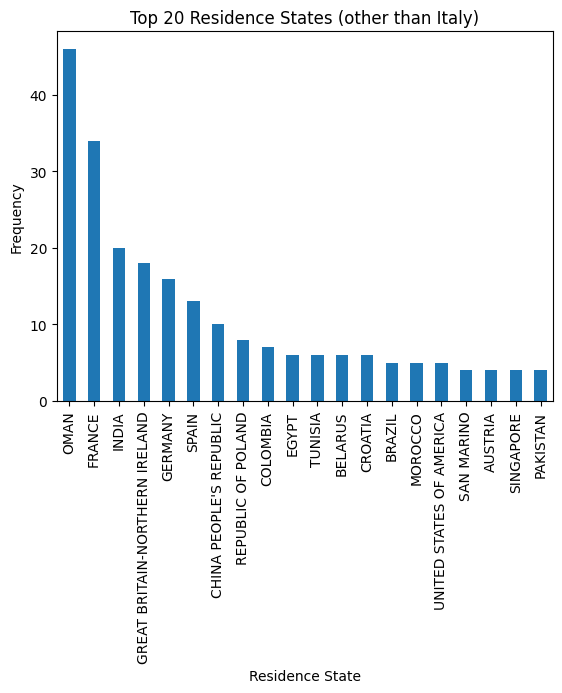

In [28]:
res_state_counts = Counter(df[df['Residence State'] != 'ITALY']['Residence State'])
res_state_df = pd.DataFrame(res_state_counts.items(), columns=['Residence State', 'Count'])
res_state_df = res_state_df.sort_values(by='Count', ascending=False)
res_state_df.head(20).plot(x='Residence State', y='Count', kind='bar', legend=False)
plt.title('Top 20 Residence States (other than Italy)')
plt.ylabel('Frequency')
plt.show()

In [29]:
df['Residence Italian Region'] = df['Residence'].apply(lambda x: x if x in italy_list else 'Not in ITALY')

In [30]:
df.loc[
    (df['Residence State'] == 'ITALY') & (df['Residence Italian Region'] == 'Not in ITALY'),
    'Residence Italian Region'
] = 'Not Specified'

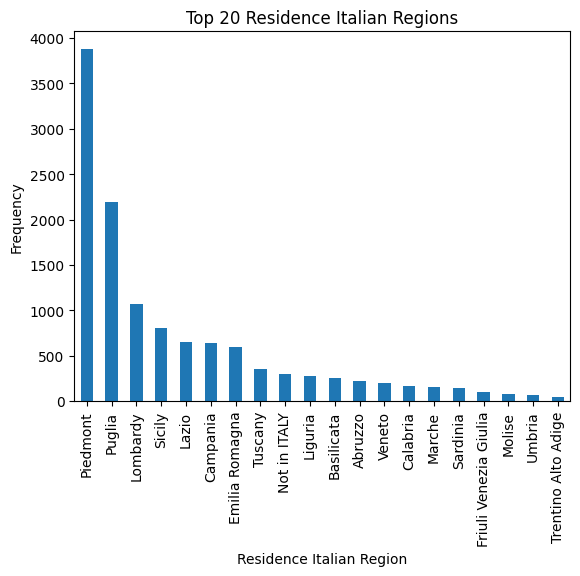

In [31]:
it_reg_counts = Counter(df['Residence Italian Region'])
it_reg_df = pd.DataFrame(it_reg_counts.items(), columns=['Residence Italian Region', 'Count'])
it_reg_df = it_reg_df.sort_values(by='Count', ascending=False)
it_reg_df.head(20).plot(x='Residence Italian Region', y='Count', kind='bar', legend=False)
plt.title('Top 20 Residence Italian Regions')
plt.ylabel('Frequency')
plt.show()

In [32]:
european_countries = [
    'ALBANIA', 'AUSTRIA', 'BELARUS', 'BELGIUM', 'BULGARIA', 'CROATIA', 'CZECH REPUBLIC',
    'FRANCE', 'GERMANY', 'GREAT BRITAIN-NORTHERN IRELAND', 'GREECE', 'ITALY', 'LATVIA',
    'LITHUANIA', 'LUXEMBOURG', 'MALTA', 'MOLDOVA', 'MONACO', 'MONTENEGRO', 'NETHERLANDS',
    'NORWAY', 'POLAND', 'PORTUGAL', 'ROMANIA', 'RUSSIA', 'SAN MARINO', 'SERBIA', 'SLOVAKIA',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'UKRAINE'
]
df['European Residence'] = df['Residence State'].apply(lambda x: 'Yes' if x in european_countries else 'No')

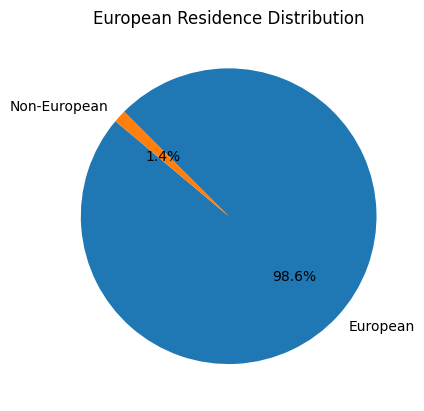

In [33]:
eu_distrib = Counter(df['European Residence'])
eu_distrib_df = pd.DataFrame(eu_distrib.items(), columns=['European Residence', 'Count'])

labels = eu_distrib_df['European Residence']
labels.replace({'Yes': 'European', 'No': 'Non-European'}, inplace=True)
sizes = eu_distrib_df['Count']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('European Residence Distribution')
plt.show()

The `Residence` column could then be removed.

In [34]:
df = df.drop(columns=['Residence'])

#### **Sex**
The dataset is unbalanced with respect to the Sex feature, with 76.8% male candidates and 23.2% female candidates.

([<matplotlib.patches.Wedge at 0x7c7b4c4fd6f0>,
 [Text(0.15654062369121927, -1.0888044053613875, 'Male'),
  Text(-0.15654057272060573, 1.0888044126895817, 'Female')],
 [Text(0.08538579474066504, -0.5938933120153022, '76.8%'),
  Text(-0.0853857669385122, 0.5938933160124991, '23.2%')])

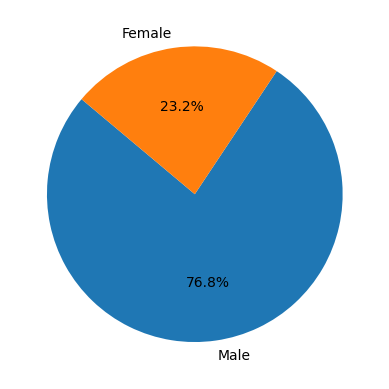

In [35]:
sex_distrib = Counter(df['Sex'])
sex_distrib_df = pd.DataFrame(sex_distrib.items(), columns=['Sex', 'Count'])

labels = sex_distrib_df['Sex']
sizes = sex_distrib_df['Count']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

#### **Protected Category**
Mapping can be applied to simplify this feature and discriminate between candidates that are part of a protected category and candidates who are not.


In [36]:
df['Protected Category'] = df['Protected Category'].replace('Article 18', 'Yes')
df['Protected Category'] = df['Protected Category'].replace('Article 1', 'Yes')

The dataset is highly unbalanced with respect to this feature, with only 0.4% candidates from protected categories.




([<matplotlib.patches.Wedge at 0x7c7b4c49ac80>,
 [Text(0.8346254005063664, -0.7165196723256019, 'No Protected Category'),
  Text(-0.8346254188500342, 0.7165196509583008, 'Protected Category')],
 [Text(0.45525021845801794, -0.39082891217760096, '99.6%'),
  Text(-0.4552502284636549, 0.3908289005227095, '0.4%')])

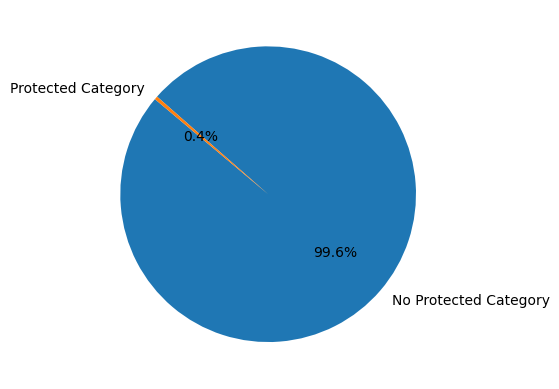

In [37]:
pr_cat_distrib = Counter(df['Protected Category'])
pr_cat_distrib_df = pd.DataFrame(pr_cat_distrib.items(), columns=['Protected Category', 'Count'])

labels = pr_cat_distrib_df['Protected Category']
labels.replace({'No': 'No Protected Category', 'Yes': 'Protected Category'}, inplace=True)
sizes = pr_cat_distrib_df['Count']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

#### **Tag**
This feature is highly irregular and will need processing in order to be useful. Some mapping could be applied to clean the data:

In [38]:
df['Tag'] = df['Tag'].replace('-', 'Not Specified')
df['Tag'] = df['Tag'].replace('.', 'Not Specified')
df['Tag'] = df['Tag'].replace('X', 'Not Specified')

In [39]:
print(df['Tag'].unique())

['AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/VENUS, VHDL, FPGA'
 '-, C, C++, DO178, LABVIEW, SOFTWARE DEVELOPMENT' 'PROCESS ENG.' ...
 '-, SOLIDWORKS, NX, CREO, INENTOR, GT POWER, AMESIM' 'SQL, UNIX'
 '-, ENVIRONMENTAL QUALITY, ENVIRONMENTAL MANAGER, ENVIRONMENTAL PROJECT ENGINEER, ISO 14001, ENVIRONMENTAL MANAGEMENT , ISO 14001, ENVIRONMENTAL MANAGEMENT, OFFSHORE']


In [44]:
all_keywords = df['Tag'].str.split(', ').explode()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'Not Specified'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '.'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '-'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'X'].index, inplace=True)
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

,Keyword,Count
20,MATLAB,576
3,C++,312
2,C,305
21,SIMULINK,305
107,SOLIDWORKS,299
35,PYTHON,275
137,EXCEL,177
52,JAVA,176
136,OFFICE,143
205,AUTOCAD,129


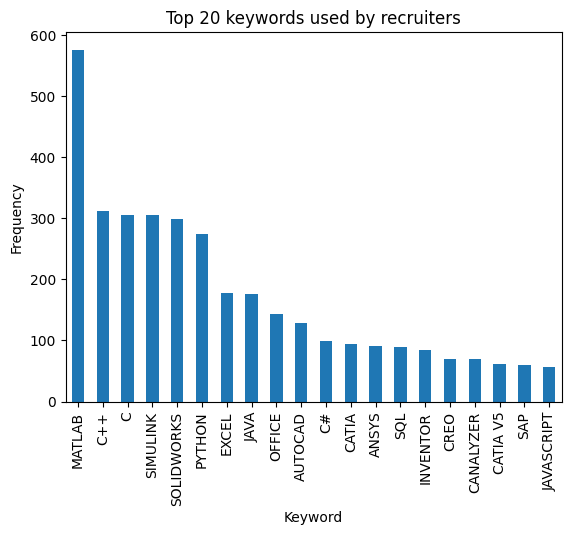

In [46]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title('Top 20 keywords used by recruiters')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


#### **Study Area**

In [51]:
print(f"There are {len(df['Study Area'].unique())} different <Study Area> values:\n {df['Study Area'].unique()} \n")

There are 48 different <Study Area> values:
 ['Automation/Mechatronics Engineering' 'computer engineering'
 'chemical engineering' 'Legal' 'Mechanical engineering'
 'Telecommunications Engineering' 'Economic - Statistics'
 'Materials Science and Engineering' 'Other scientific subjects'
 'Biomedical Engineering' 'electronic Engineering'
 'Information Engineering'
 'Aeronautical/Aerospace/Astronautics Engineering'
 'Energy and Nuclear Engineering' 'Informatics' 'Management Engineering'
 'Automotive Engineering' 'industrial engineering' 'Other' 'Surveyor'
 'Electrical Engineering' 'Scientific maturity' 'Chemist - Pharmaceutical'
 'Political-Social' 'Other humanities subjects' 'Geo-Biological'
 'Civil/Civil and Environmental Engineering' 'Psychology' 'Linguistics'
 'Agriculture and veterinary' 'Literary' 'Humanistic high school diploma'
 'Accounting' 'Communication Sciences' 'Safety Engineering' 'Architecture'
 'Mathematics' 'construction Engineering' 'Petroleum Engineering'
 'Naval Engine

In [52]:
study_areas_counts = Counter(df['Study Area'])

study_areas_counts_df = pd.DataFrame(study_areas_counts.items(), columns=['Study Area', 'Count'])
study_areas_counts_df = study_areas_counts_df.sort_values(by='Count', ascending=False)

study_areas_counts_df.head(10)

,Study Area,Count
4,Mechanical engineering,2235
1,computer engineering,1344
12,Aeronautical/Aerospace/Astronautics Engineering,951
9,Biomedical Engineering,924
17,industrial engineering,901
15,Management Engineering,798
10,electronic Engineering,685
18,Other,567
11,Information Engineering,485
0,Automation/Mechatronics Engineering,430


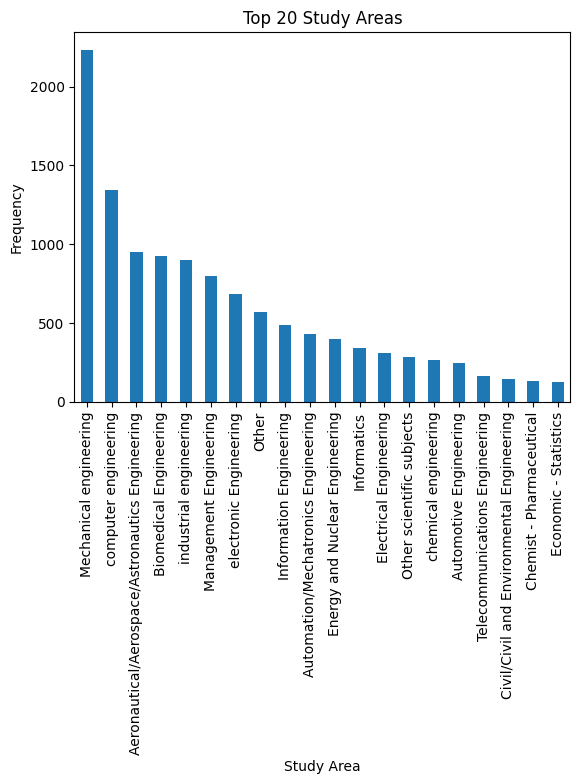

In [53]:
study_areas_counts_df.head(20).plot(x='Study Area', y='Count', kind='bar', legend=False)
plt.title('Top 20 Study Areas')
plt.ylabel('Frequency')
plt.xlabel('Study Area')
plt.show()

#### **Study Title**

In [54]:
print(f"There are {len(df['Study Title'].unique())} different <Study Title> values:\n {df['Study Title'].unique()} \n")

There are 7 different <Study Title> values:
 ['Five-year degree' 'Doctorate' 'High school graduation'
 'Three-year degree' "master's degree" 'Middle school diploma'
 'Professional qualification'] 



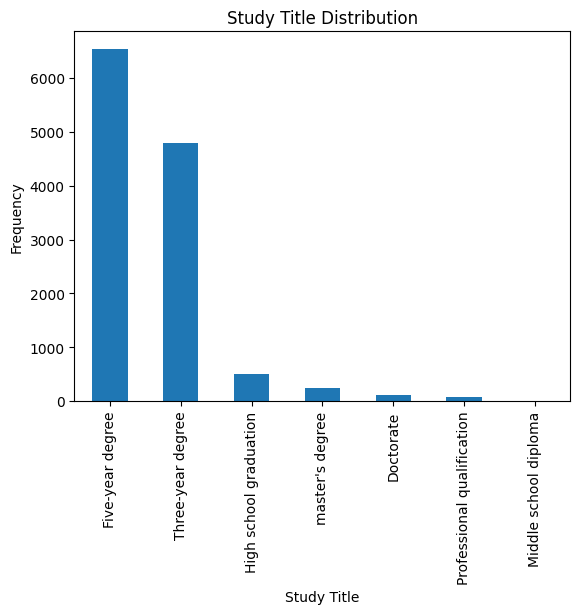

In [64]:
study_title_distrib = df['Study Title'].value_counts()
study_title_df = pd.DataFrame(study_title_distrib.items(), columns=['Study Title', 'Count'])
study_title_df.plot(x='Study Title', y='Count', kind='bar', legend=False)
plt.title('Study Title Distribution')
plt.ylabel('Frequency')
plt.xlabel('Study Title')
plt.show()

#### **Years Experience**

In [56]:
print(f"There are {len(df['Years Experience'].unique())} different <Years Experience> categories:\n {df['Years Experience'].unique()} \n")

There are 7 different <Years Experience> categories:
 ['[1-3]' '[7-10]' '[3-5]' '[5-7]' '[+10]' '[0]' '[0-1]'] 



Text(0, 0.5, 'Frequency')

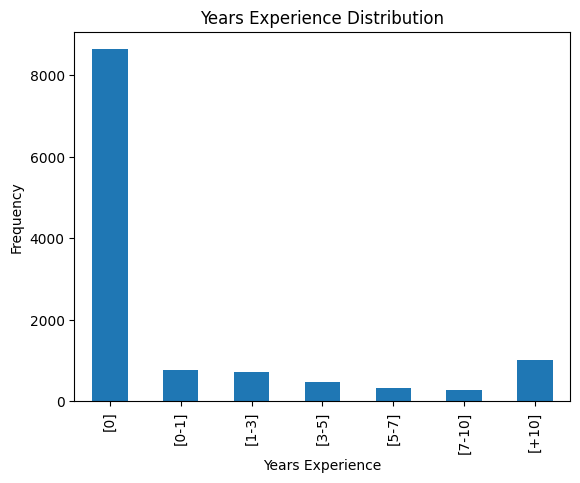

In [63]:
custom_order = ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
df['Years Experience'] = pd.Categorical(df['Years Experience'], categories=custom_order, ordered=True)

years_exp_counts = Counter(df['Years Experience'].sort_values())
years_exp_df = pd.DataFrame(years_exp_counts.items(), columns=['Years Experience', 'Count'])
years_exp_df.plot(x='Years Experience', y='Count', kind='bar', legend=False)
plt.title('Years Experience Distribution')
plt.ylabel('Frequency')

#### **Sector**
This feature doesn't seem relevant as its most frequent values are "*Not Specified*" and "*Others*".

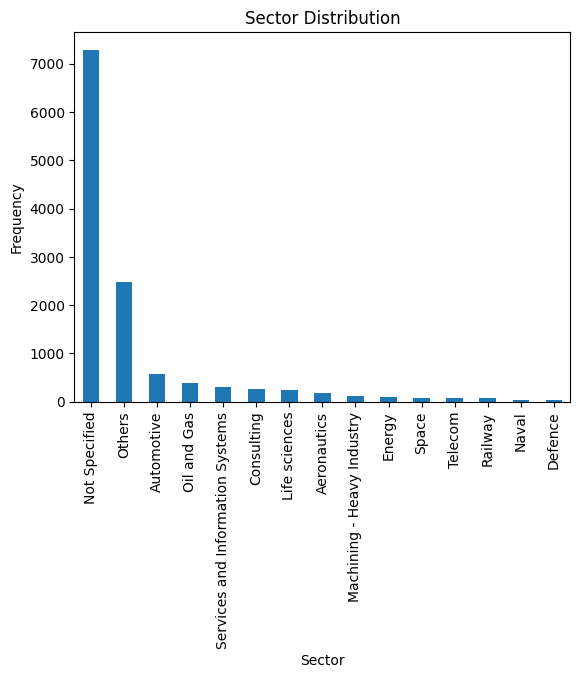

In [61]:
sector_counts = Counter(df['Sector'])
sector_df = pd.DataFrame(sector_counts.items(), columns=['Sector', 'Count'])
sector_df = sector_df.sort_values(by='Count', ascending=False)
sector_df.plot(x='Sector', y='Count', kind='bar', legend=False)
plt.title('Sector Distribution')
plt.ylabel('Frequency')
plt.show()

#### **Event_type__val**

In [60]:
print(f"There are {len(df['Event_Type__Val'].unique())} different values for <Event_Type__Val:\n {df['Event_Type__Val'].unique()}")

There are 13 different values for <Event_Type__Val:
 ['BM interview' 'Candidate notification' 'Qualification Meeting'
 'Technical interview' 'HR interview' 'CV request' 'Contact note'
 'Inadequate CV' 'Economic proposal' 'Research association'
 'Sending SC to customer' 'Not Specified' 'Commercial note']


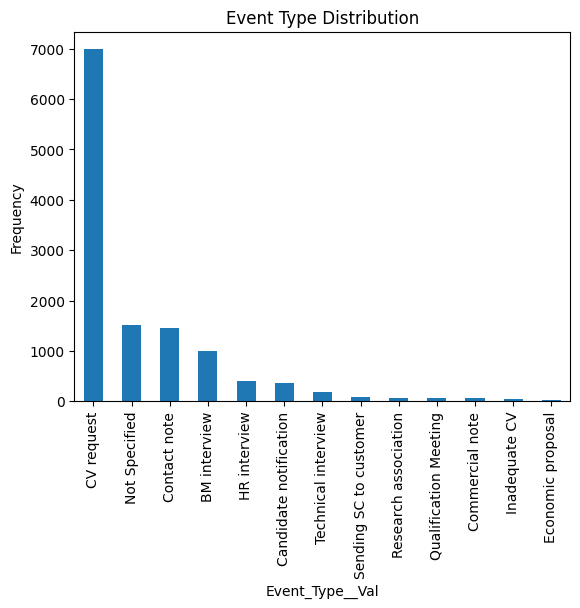

In [62]:
etv_distrib = Counter(df['Event_Type__Val'])
etv_distrib_df = pd.DataFrame(etv_distrib.items(), columns=['Event_Type__Val', 'Count'])
etv_distrib_df = etv_distrib_df.sort_values(by='Count', ascending=False)
etv_distrib_df.plot(x='Event_Type__Val', y='Count', kind='bar', legend=False)
plt.title('Event Type Distribution')
plt.ylabel('Frequency')
plt.show()

The most frequent type of **event** is the "*CV Request*", meaning that Akkodis has not yet received anything from that candidate. This could mean that for this kind of candidates there's no way to determine whether they are eligible or not for the position. The distribution of `Candidate State` values for candidates that have not yet sent their CV is the following:

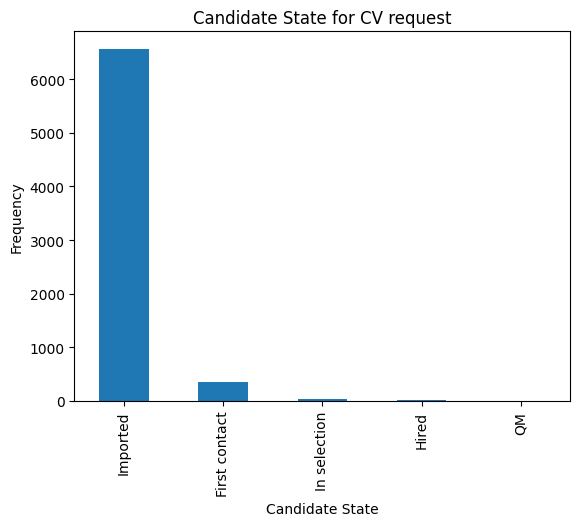

In [69]:
cv_req_counts = df[df['Event_Type__Val'] == 'CV request']['Candidate State'].value_counts()
cv_req_df = pd.DataFrame(cv_req_counts.items(), columns=['Candidate State', 'Count'])
cv_req_df.plot(x='Candidate State', y='Count', kind='bar', legend=False)
plt.title('Candidate State for CV request')
plt.ylabel('Frequency')
plt.show()

The majority of this candidates have "*imported*" as `Candidate State`, which means that there's no way to evaluate their suitability.



In [88]:
nocv_imp_count = df[(df['Event_Type__Val'] == 'CV request') & (df['Candidate State'] == 'Imported')].shape[0]

print(f"The {nocv_imp_count/df.shape[0] *100:.2f}% of the dataset is composed of 'Imported' candidates that have not sent their CV yet")

The 53.52% of the dataset is composed of 'Imported' candidates that have not sent their CV yet


#### **Event_feedback**
This feature could be simplified with mapping, reducing the number of possible values from 16 to 3:

In [70]:
print(f"There are {len(df['Event_Feedback'].unique())} possible values for <Event_Feedback>:\n {df['Event_Feedback'].unique()}")

There are 16 possible values for <Event_Feedback>:
 ['OK' 'Not Specified' 'KO (technical skills)' 'OK (waiting for departure)'
 'KO (proposed renunciation)' 'OK (live)' 'KO (mobility)' 'KO (manager)'
 'KO (retired)' 'OK (hired)' 'KO (seniority)' 'KO (ral)'
 'OK (other candidate)' 'KO (opportunity closed)' 'KO (lost availability)'
 'KO (language skills)']


In [71]:
df['Event_Feedback'] = df['Event_Feedback'].apply(lambda x: 'OK' if 'OK' in x else x)
df['Event_Feedback'] = df['Event_Feedback'].apply(lambda x: 'KO' if 'KO' in x else x)

In [72]:
print(f"After mapping there are now {len(df['Event_Feedback'].unique())} possible values for <Event_Feedback>:\n {df['Event_Feedback'].unique()}")

After mapping there are now 3 possible values for <Event_Feedback>:
 ['OK' 'Not Specified' 'KO']


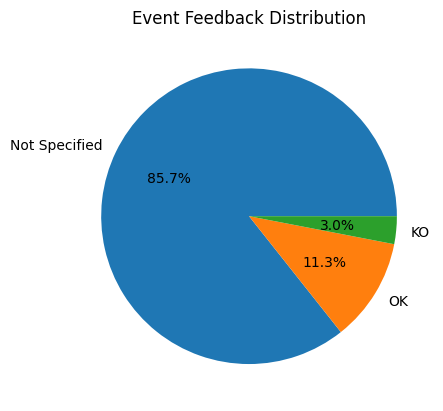

In [73]:
ok_ko_distrib = df['Event_Feedback'].value_counts()
ok_ko_distrib_df = pd.DataFrame(ok_ko_distrib.items(), columns=['Event_Feedback', 'Count'])

ok_ko_distrib = ok_ko_distrib_df['Count']
labels = ok_ko_distrib_df['Event_Feedback']

plt.pie(ok_ko_distrib, labels=labels, autopct='%1.1f%%')
plt.title('Event Feedback Distribution')
plt.show()

## Data Visualization
### **Sex and Candidate State**

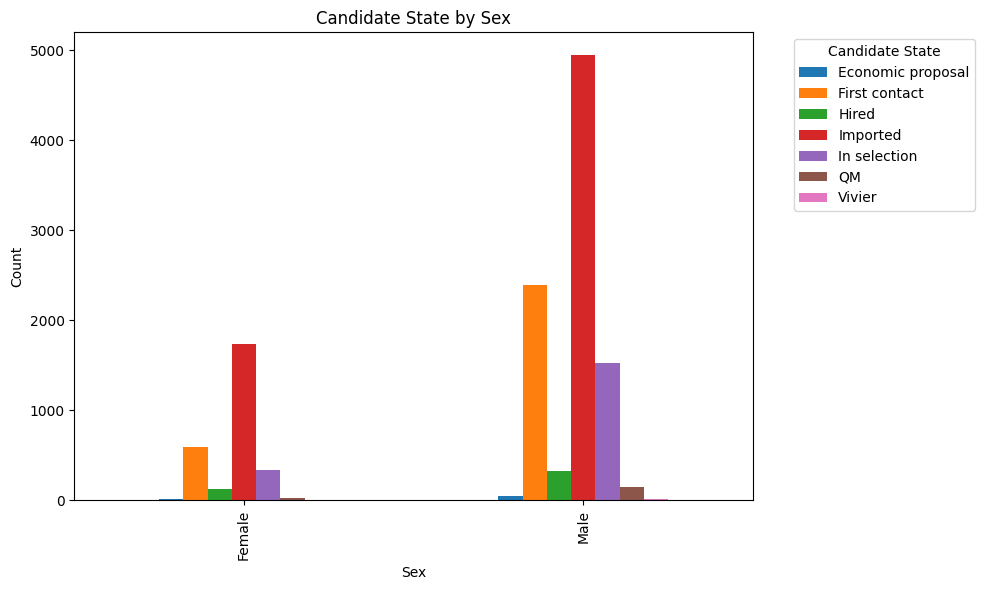

In [74]:
pivot = df.pivot_table(index='Sex', columns='Candidate State', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Candidate State by Sex')
plt.ylabel('Count')
plt.xlabel('Sex')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


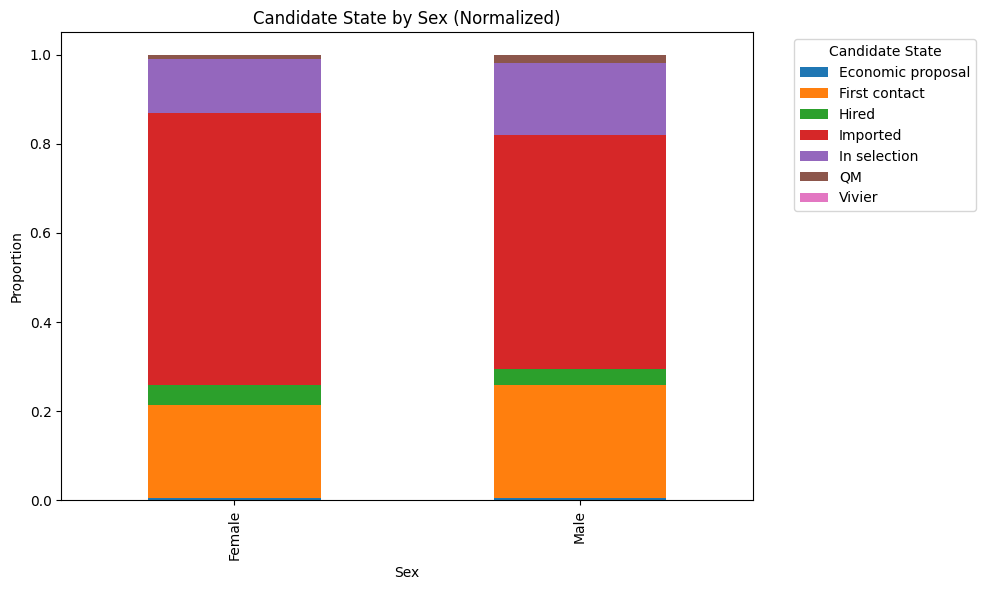

In [75]:
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Candidate State by Sex (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Sex')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### **Protected Category and Candidate State**

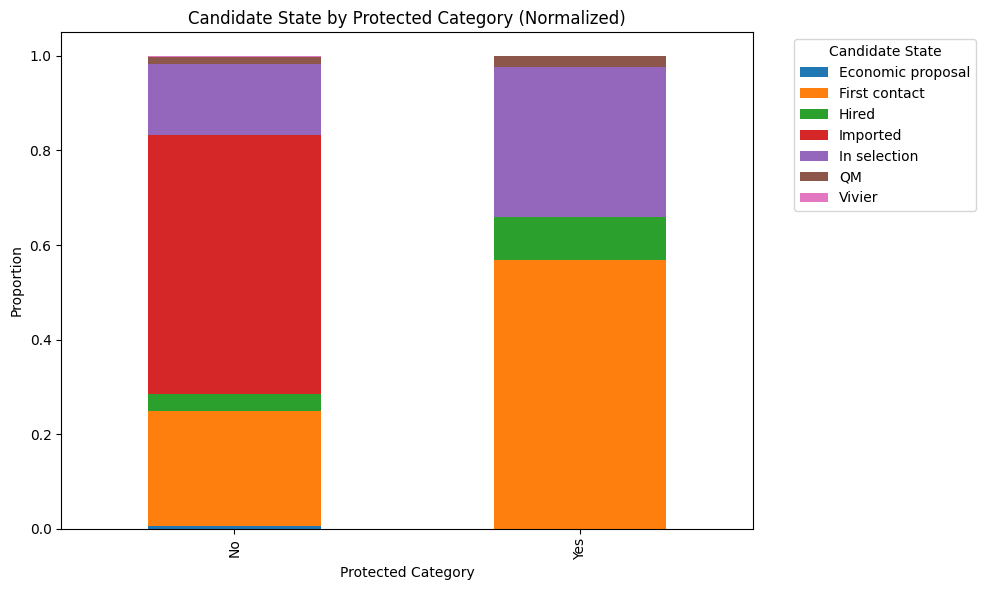

In [76]:
pivot = df.pivot_table(index='Protected Category', columns='Candidate State', aggfunc='size', fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Candidate State by Protected Category (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Protected Category')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Age Range and Candidate State**

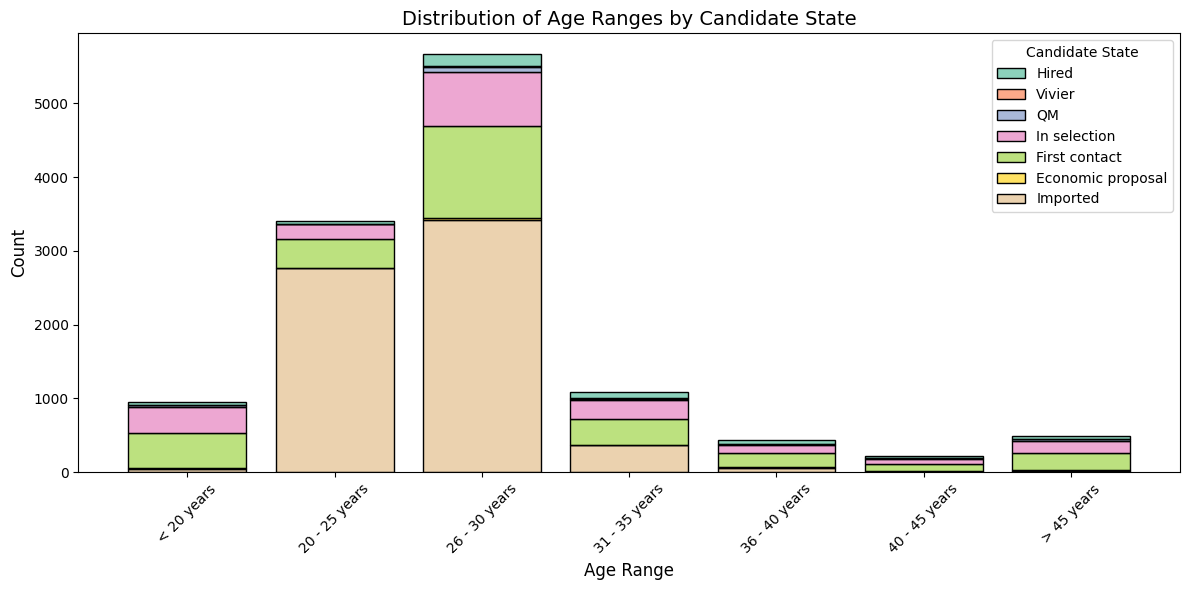

<ipython-input-101-4e359a3f635f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


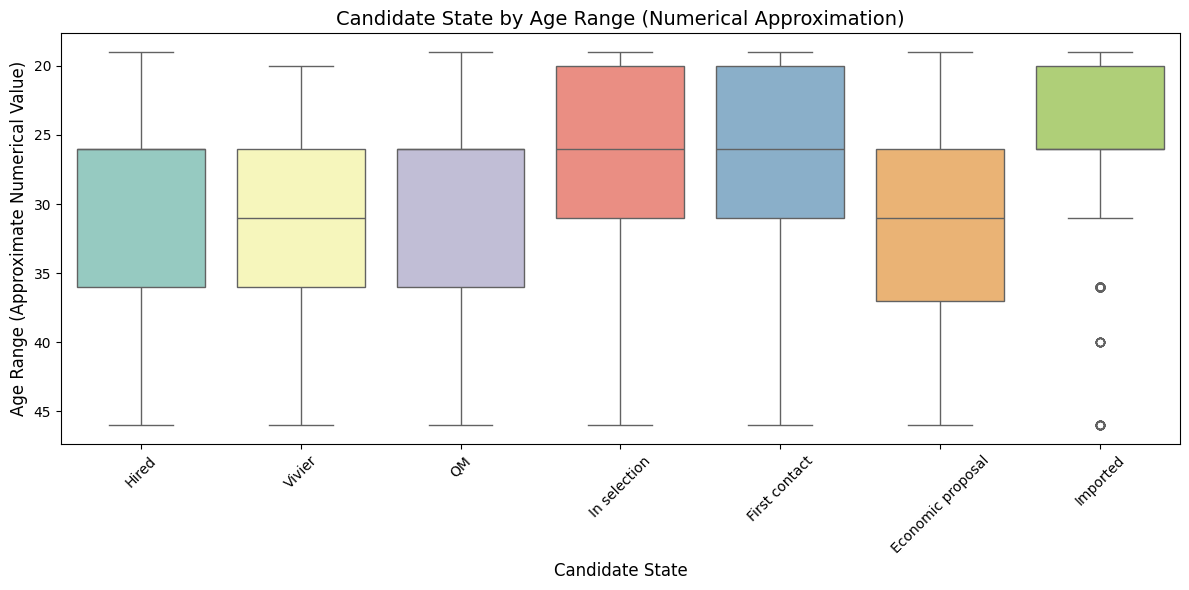

In [101]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data= df,
    x='Age Range',
    hue='Candidate State',
    multiple='stack',
    palette='Set2',
    shrink=0.8,
    legend=True
)
plt.title("Distribution of Age Ranges by Candidate State", fontsize=14)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Candidate State',
    y=df['Age Range'].map(lambda x: int(x.split('-')[0]) if '-' in x else (19 if '<' in x else 46)),
    palette='Set3'
)
plt.title("Candidate State by Age Range (Numerical Approximation)", fontsize=14)
plt.xlabel("Candidate State", fontsize=12)
plt.ylabel("Age Range (Approximate Numerical Value)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **Correlation**

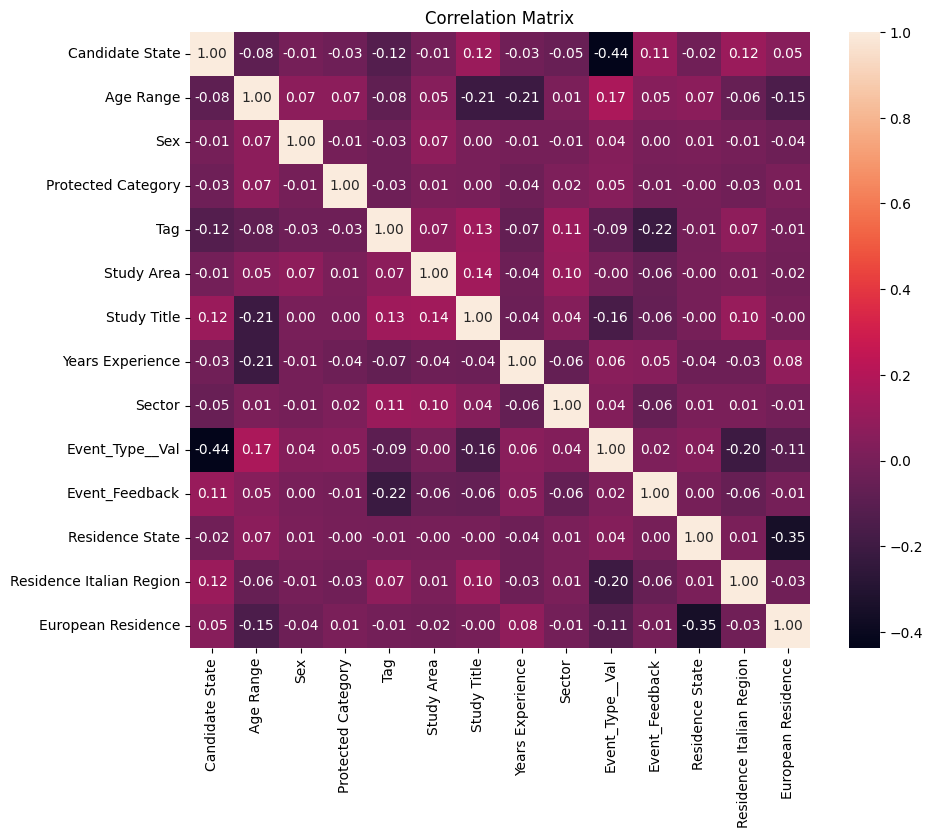

In [85]:
df_encoded = df.copy()

age_mapping = {
    '< 20 years': 1,
    '20 - 25 years': 2,
    '26 - 30 years': 3,
    '31 - 35 years': 4,
    '36 - 40 years': 5,
    '40 - 45 years': 6,
    '> 45 years': 7
}

df_encoded['Age Range'] = df_encoded['Age Range'].map(age_mapping)

le = LabelEncoder()

for col in df_encoded.columns:
    if col != 'Age Range':
        df_encoded[col] = le.fit_transform(df_encoded[col])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()